# Facial Emotion Recognition Project

### Imports/Setup

In [1]:
# Imports
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf

# Set seed
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

### Load data

In [2]:
# Training and validation data
ds_train_ = image_dataset_from_directory(
    'images/train',
    labels='inferred',
    label_mode='categorical',
    image_size=[48, 48],
    interpolation='nearest',
    seed=31415,
    validation_split=0.3,
    subset='training',
    shuffle=True
)
ds_valid_ = image_dataset_from_directory(
    'images/train',
    labels='inferred',
    label_mode='categorical',
    image_size=[48, 48],
    interpolation='nearest',
    seed=31415,
    validation_split=0.3,
    subset='validation',
    shuffle=False
)

Found 28821 files belonging to 7 classes.
Using 20175 files for training.
Found 28821 files belonging to 7 classes.
Using 8646 files for validation.


In [3]:
ds_test_ = image_dataset_from_directory(
    'images/test',
    labels='inferred',
    label_mode='categorical',
    image_size=[48, 48],
    interpolation='nearest',
    shuffle=True
)

Found 7066 files belonging to 7 classes.


In [4]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test = (
    ds_test_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

### Model

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.InputLayer(input_shape=[48, 48, 3]),
    
    # Preprocessing (Data Augmentation)
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(7, activation='softmax'),
])

### Optimizer and loss function

In [6]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

### Early Stopping

In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]

### Training model + Plot learning curves

Epoch 1/10
631/631 [==============================] - 111s 169ms/step - loss: 1.8589 - categorical_accuracy: 0.2455 - val_loss: 1.9840 - val_categorical_accuracy: 0.0770
Epoch 2/10
631/631 [==============================] - 95s 150ms/step - loss: 1.7113 - categorical_accuracy: 0.2930 - val_loss: 1.8747 - val_categorical_accuracy: 0.2390
Epoch 3/10
631/631 [==============================] - 102s 162ms/step - loss: 1.5950 - categorical_accuracy: 0.3556 - val_loss: 1.5819 - val_categorical_accuracy: 0.4888
Epoch 4/10
631/631 [==============================] - 94s 150ms/step - loss: 1.5138 - categorical_accuracy: 0.3911 - val_loss: 1.7889 - val_categorical_accuracy: 0.4488
Epoch 5/10
631/631 [==============================] - 93s 147ms/step - loss: 1.4553 - categorical_accuracy: 0.4166 - val_loss: 1.6013 - val_categorical_accuracy: 0.5363
Epoch 6/10
631/631 [==============================] - 98s 156ms/step - loss: 1.4082 - categorical_accuracy: 0.4373 - val_loss: 1.5436 - val_categorical_a

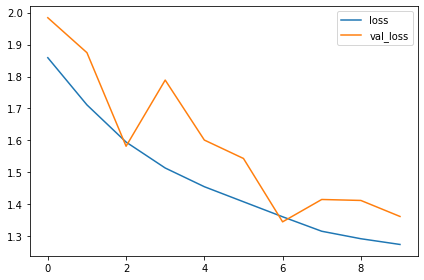

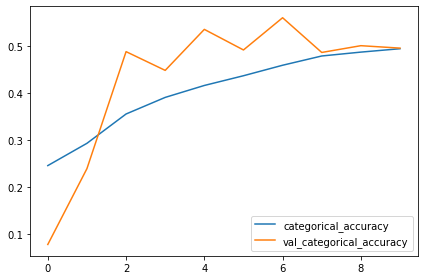

In [8]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=10,
    callbacks=[es,mc]
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

### Saving model

In [10]:
model.save('emotion_model.h5')

### Loading model

In [12]:
from keras.models import load_model
model = load_model("emotion_model.h5")

In [ ]:
predictions = model.predict(ds_test)

221/221 [==============================] - 7s 29ms/step


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
predictions[:7]
pred = predictions > 0.3
# print(classification_report(list(ds_test.as_numpy_iterator()),pred))
# cm=confusion_matrix(ds_test.class_names, pred)
# print(cm)

5186


In [ ]:
print(list(ds_test.as_numpy_iterator())[0])